In [3472]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
plt.rcParams['figure.figsize'] = (20,10)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

'''%matplotlib inline --> without it the code will be run but no plot will appeare
to control the defaults of almost every property in Matplotlib: figure size and DPI, line width,
color and style, axes, axis and grid properties, text and font properties and so on.'''

In [3473]:
# read csv file
df1 = pd.read_csv('DataSet/bengaluru_house_prices.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3474]:
# number of columns and rows 
df1.shape
# shape() --> TypeError: 'tuple' object is not callable

(13320, 9)

Data Cleaning

In [3475]:
# examine area_type featuer
df1.groupby('area_type')['area_type'].agg('count')
# df1.groupby('area_type')['area_type'].count()

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [3476]:
# to simplify the model --> drop some columns
df2 = df1.drop(['area_type','availability', 'society' , 'balcony'] , axis = 'columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [3477]:
# data cleaning process
# tell me the number of rows where particulare columns is null --> isnull()
# tell me the number of rows where particulare columns is not null --> notnull()
# sum of isnull() and notnull() == count from shape
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [3478]:
# drop the null values 
# i have 2 choises here : if the number of null is too small in comparesion with the number of columns 
# (in my case 90 from 13320) -- > drop it 
# else if it represent a high pergentage --> take the median and fill the null with it
df3 = df2.dropna()
# --> check if they are droped
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [3479]:
# navigate the size column 
df3['size'].unique()
# give me all the unique values in the column

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [3480]:
# BHK = Bedroom --> so i must keep the number only to avoid under or over estimation in the model
# by split the string 'which give me a list of char then keep in char with index 0 only' and save them in a new column
# the new column 'bhk'
# by .apply() i can apply any method of function between the () to a selected elements
df3['bhk'] = df3['size'].apply(lambda x : int(x.split(' ')[0]))
df3.head()

/tmp/ipykernel_11400/1791557361.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x : int(x.split(' ')[0]))


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [3481]:
# df3.drop(['size'], axis = 'columns')
# df3.head()
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [3482]:
df3 = df3.drop(['size'] , axis = 'columns')
df3.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


In [3483]:
df3['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [3484]:
from numpy import mean
def clean_total_sqft(x):
    y = x.split('-')
    if len(y) == 2 :
        return (float(y[0]) + float(y[1]))/2
    
    try:
        return float(x)
    except:
        # numbers = [int(i) for i in z if type(i)==type(5)]
        return None    

In [3485]:
clean_total_sqft('50a')

In [3486]:
df4 = df3.copy()
df4.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


In [3487]:
# df4['total_sqft']= df4['total_sqft'].apply(clean_total_sqft)
df4.total_sqft= df4.total_sqft.apply(clean_total_sqft)

In [3488]:
df4.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [3489]:
df4.loc[648]

location      Arekere
total_sqft        NaN
bath              9.0
price           265.0
bhk                 9
Name: 648, dtype: object

In [3490]:
df4.isnull().sum()

location       0
total_sqft    46
bath           0
price          0
bhk            0
dtype: int64

In [3491]:
df4 = df4.dropna()
df4.isnull().sum()

location      0
total_sqft    0
bath          0
price         0
bhk           0
dtype: int64

Engineering Feature

In [3492]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000 /df5['total_sqft']
df5.location= df5.location.apply(lambda x : x.strip())
df5.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [3493]:
len(df5['location'].unique())

1287

In [3494]:
location_state = df5.groupby('location')['location'].count().sort_values(ascending= False)
location_state

location
Whitefield               533
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           264
Thanisandra              235
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Kannur                     1
whitefiled                 1
Name: location, Length: 1287, dtype: int64

In [3495]:
location_less_than_10 = location_state[location_state <= 10]
len(location_less_than_10)

1047

In [3496]:
df5.location = df5.location.apply(lambda x : 'other' if x in location_less_than_10 else x )
len(df5.location.unique())

241

In [3497]:
df5.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [3498]:
df5.shape

(13200, 6)

In [3499]:
df6 = df5[~(df5.total_sqft/ df5.bhk < 300)]
df6.shape

(12456, 6)

In [3500]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

Out-layer Removal

In [3501]:
def remove_out_layer_by_standared_deviation(df):
    df_out = pd.DataFrame()
    for key , subdf in df.groupby('location'):
        avg = np.mean(subdf.price_per_sqft)
        std = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft >= (avg-std)) & (subdf.price_per_sqft <= (avg+std))]
        df_out = pd.concat([df_out , reduced_df] , ignore_index= True)
    return df_out

In [3502]:
df7 = remove_out_layer_by_standared_deviation(df6)
df7.shape

(10242, 6)

In [3503]:
df7.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,1235.0,2.0,148.0,2,11983.805668


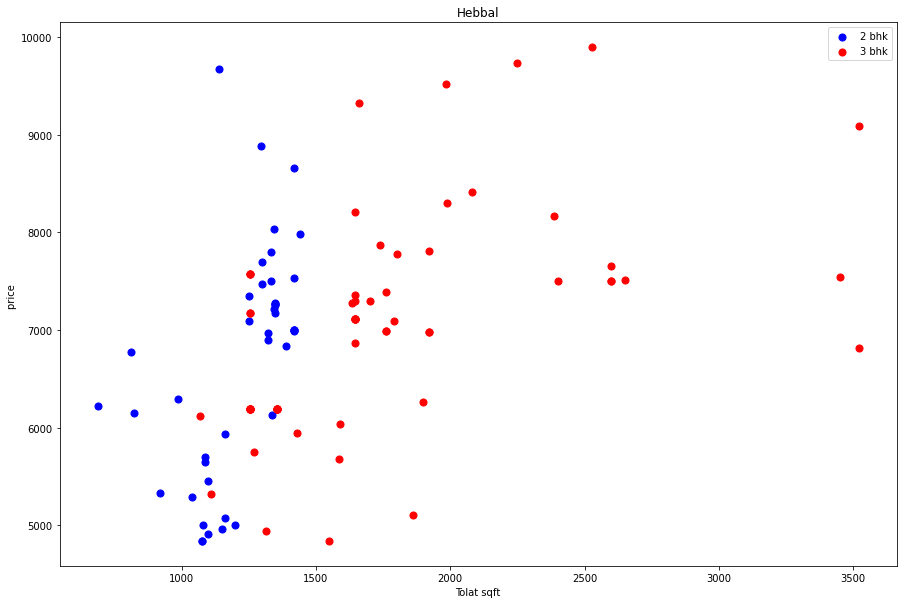

In [3504]:
def plot_by_matplot(df , location):
    bhk2=df[(df.location == location) & (df.bhk == 2)]
    bhk3=df[(df.location == location) & (df.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15 , 10)
    plt.scatter(bhk2.total_sqft , bhk2.price_per_sqft , color = 'blue' , label = '2 bhk' , s =50 )
    plt.scatter(bhk3.total_sqft , bhk3.price_per_sqft , color = 'red' , label = '3 bhk' , s =50 )
    plt.xlabel('Tolat sqft')
    plt.ylabel('price ')
    plt.title(location)
    plt.legend()

plot_by_matplot(df7 ,'Hebbal')

In [3505]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
df8.shape

(7317, 6)

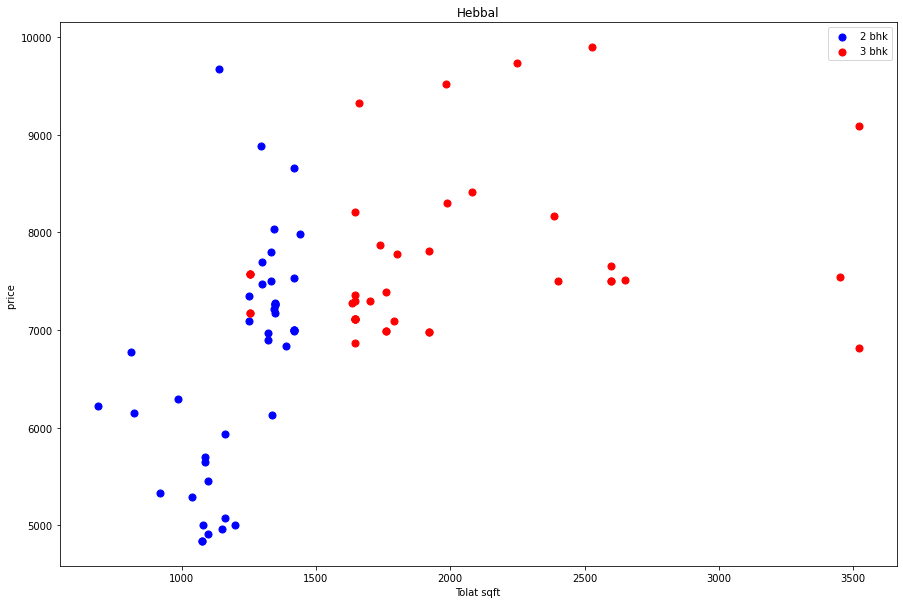

In [3506]:
def plot_by_matplot(df , location):
    bhk2=df[(df.location == location) & (df.bhk == 2)]
    bhk3=df[(df.location == location) & (df.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15 , 10)
    plt.scatter(bhk2.total_sqft , bhk2.price_per_sqft , color = 'blue' , label = '2 bhk' , s =50 )
    plt.scatter(bhk3.total_sqft , bhk3.price_per_sqft , color = 'red' , label = '3 bhk' , s =50 )
    plt.xlabel('Tolat sqft')
    plt.ylabel('price ')
    plt.title(location)
    plt.legend()

plot_by_matplot(df8 ,'Hebbal')

Text(0, 0.5, 'count')

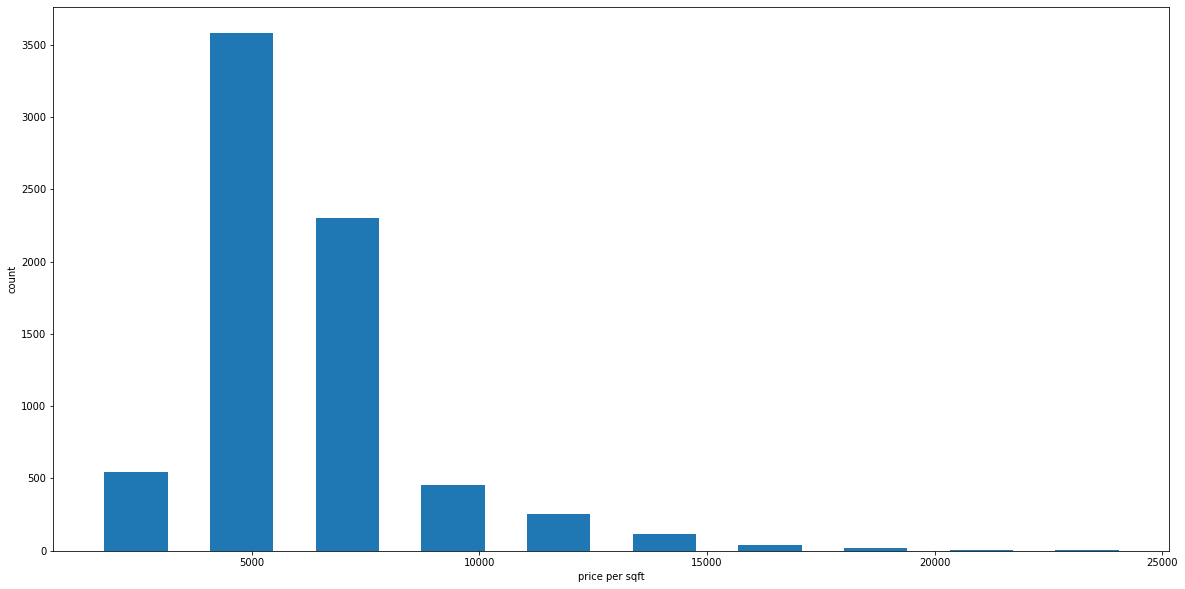

In [3507]:
matplotlib.rcParams['figure.figsize'] = (20,10)
plt.hist(df8.price_per_sqft , rwidth=0.6)
plt.xlabel('price per sqft')
plt.ylabel('count')

In [3508]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'count')

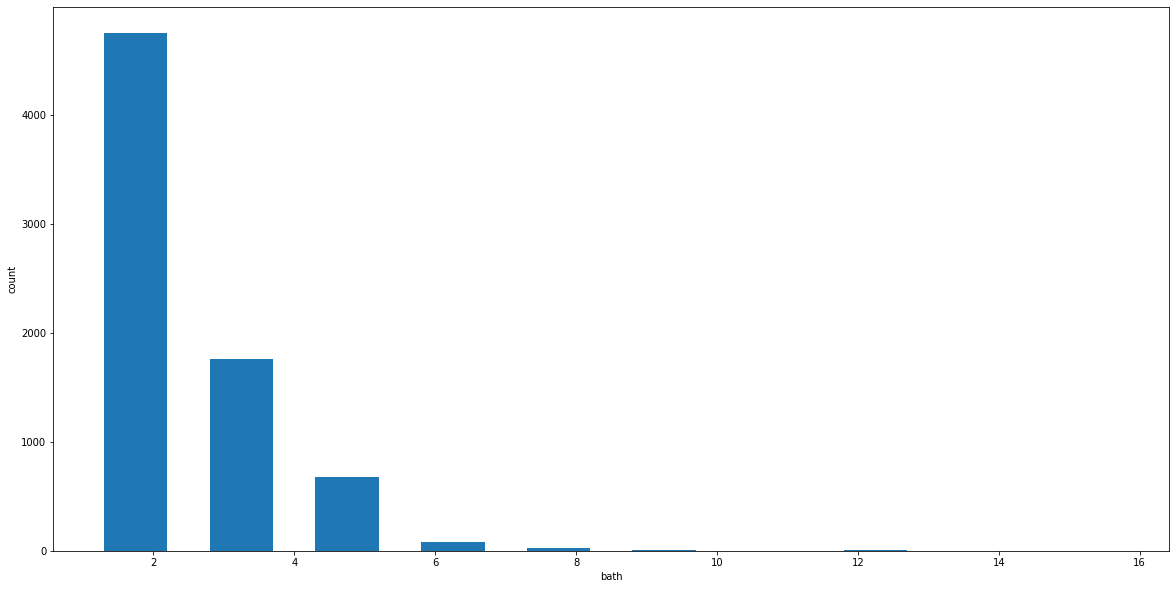

In [3509]:
matplotlib.rcParams['figure.figsize'] = (20,10)
plt.hist(df8.bath , rwidth=0.6)
plt.xlabel('bath')
plt.ylabel('count')

In [3510]:
df8[df8.bath > df8.bhk+2]

,location,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,1806.0,6.0,116.0,3,6423.034330
8408,other,11338.0,9.0,1000.0,6,8819.897689


In [3511]:
df9 = df8[df8.bath < df8.bhk+2]
df9.shape

(7239, 6)

In [3512]:
df10 = df9.copy()
df10 = df10.drop(['price_per_sqft'] , axis= 'columns')
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


Model Building

In [3513]:
# One-hot encoding
dummy = pd.get_dummies(df10.location)
df11 = pd.concat([df10,dummy.drop('other', axis = 'columns')] , axis= 'columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3514]:
df12 = df11.drop('location' , axis= 'columns')
df12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Linear Regression

In [3515]:
# x contain only the independent varialbes 
X = df12.drop(['price'] , axis= 'columns')
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3516]:
Y = df12.price
# y.head()

In [3517]:
x_train , x_test , y_train , y_test = train_test_split(X , Y , test_size = 0.2 , random_state=10)

In [3518]:
model = LinearRegression()
model.fit(x_train , y_train)
test_accuracy = model.score(x_test, y_test)
test_accuracy 

0.8629132245229447

Try to optimize the model

In [3519]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import load_digits
# from sklearn.model_selection import train_test_split

In [3520]:
# digits = load_digits()
# x_train , x_test , y_train , y_test = train_test_split(digits.data , digits.target , test_size= 0.3)

Logistic Regression

In [3521]:
# logistic_regression_model = LogisticRegression(max_iter=100000)
# logistic_regression_model.fit(x_train, y_train)
# logistic_regression_model.score(x_test , y_test)

Random Forest Classifier

In [3522]:
# random_forest_classifier_model = RandomForestClassifier(n_estimators= 250)
# random_forest_classifier_model.fit(x_train , y_train)
# random_forest_classifier_model.score(x_test , y_test)

Prediction function

In [3523]:
def predict_price(location	, sqft , bath , bhk):
    global x
    loc_index = np.where(X.columns== location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return model.predict([x])[0]

predict_price = predict_price


In [3524]:
# df11.location.unique()

In [3525]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

/home/ayat/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


86.0806228498639

In [3526]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

/home/ayat/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.8657025831163

In [3527]:
predict_price('Indira Nagar',1000, 2, 2)

/home/ayat/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


193.3119773317972

In [3528]:
predict_price('Indira Nagar',1000, 3, 3)

/home/ayat/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


195.52689759854482

Save the model with pickle
i save the predict_price function also in pickle file here : by saving the function into variable

In [3529]:
import pickle

In [3530]:
with open('func_pickle.pickle' , 'wb') as model_saver:
    pickle.dump(predict_price, model_saver )

In [3531]:
with open ('func_pickle.pickle' , 'rb') as model_saver:
    pickle_func = pickle.load(model_saver)

In [3532]:
pickle_func('Indira Nagar',1000, 3, 3)

/home/ayat/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


195.52689759854482

save to json

In [3533]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))